<h1>📊 Regional Sales Analysis</h1>

<p>
<strong>Problem Statement:</strong><br>
Sales teams often lack a clear, data-driven understanding of regional performance, making it difficult to identify growth opportunities and optimize resources. 
This notebook analyses and visualizes regional sales data to uncover trends, evaluate profitability, and support strategic decision-making.
</p>

<h2>🚀 Overview</h2>
<ul>
  <li>Clean and prepare sales data</li>
  <li>Explore regional and customer performance</li>
  <li>Visualize trends and key drivers</li>
</ul>

<h2>📈 Insights</h2>
<ul>
  <li>Highlight top-performing products and regions</li>
  <li>Spot underperforming areas with growth potential</li>
  <li>Support data-driven strategy</li>
</ul>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

In [2]:
Path("figures").mkdir(exist_ok=True)
def savefig(name):
    plt.savefig(Path("figures")/f"{name}.png", dpi=300, bbox_inches='tight')

<h3>🧹 Clean and Prepare Data</h3>

<p>
First, we'll load the datasets, merge them into a single table, and inspect the structure using 
<code>.head()</code>.  
To keep the notebook uncluttered, we’ll only preview the merged data table.
</p>


In [3]:
df_sales_orders = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='Sales Orders')

df_customers = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='Customers')

df_regions = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='Regions')
df_regions['area_code'] = pd.to_numeric(df_regions['area_code'], errors='coerce').astype('Int64')

df_state_regions = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='State Regions')

df_products = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='Products')

df_2017_budgets = pd.read_excel('Regional Sales Dataset.xlsx', engine='openpyxl', sheet_name='2017 Budgets')

df_merged = df_sales_orders.merge(df_customers, left_on='Customer Name Index', right_on='Customer Index', how='left')

df_merged = df_merged.merge(df_products, left_on='Product Description Index', right_on='Index', how='left')

df_merged = df_merged.merge(df_regions, left_on='Delivery Region Index', right_on='id', how='left')

df_merged = df_merged.merge(df_state_regions, left_on='state_code', right_on='Column1', how='left')

df_merged.head()  


,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,...,area_code,population,households,median_income,land_area,water_area,time_zone,Column1,Column2,Column3
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,...,912,145674,52798,36466,268318796,13908113,America/New York,GA,Georgia,South
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,...,317,55586,20975,54176,72276415,1883,America/Indiana/Indianapolis,IN,Indiana,Midwest
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,...,925,79510,26020,124759,62489257,386195,America/Los Angeles,CA,California,West
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,...,812,84067,30232,30019,60221613,475857,America/Indiana/Indianapolis,IN,Indiana,Midwest
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,...,959,58007,24141,63158,70972793,720300,America/New York,CT,Connecticut,Northeast


<p>
Next, we'll use <code>.info()</code> to quickly check for null values 
and review the data types of each column.
</p>


In [4]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   OrderNumber                64104 non-null  object        
 1   OrderDate                  64104 non-null  datetime64[ns]
 2   Customer Name Index        64104 non-null  int64         
 3   Channel                    64104 non-null  object        
 4   Currency Code              64104 non-null  object        
 5   Warehouse Code             64104 non-null  object        
 6   Delivery Region Index      64104 non-null  int64         
 7   Product Description Index  64104 non-null  int64         
 8   Order Quantity             64104 non-null  int64         
 9   Unit Price                 64104 non-null  float64       
 10  Line Total                 64104 non-null  float64       
 11  Total Unit Cost            64104 non-null  float64       
 12  Cust

<p>
Lastly, before moving on to exploring the data, we'll drop unnecessary columns 
and rename others for consistency.  
For convenience, we used the Data Wrangler extension in VS Code to streamline this step.  
Finally, we'll preview the table with <code>.head()</code> to verify everything is in order.
</p>



In [5]:
def clean_data(df_merged):
    # Drop columns: 'OrderNumber', 'Customer Name Index' and 14 other columns
    df_merged = df_merged.drop(columns=['OrderNumber', 'Customer Name Index', 'Warehouse Code', 'Delivery Region Index', 'Product Description Index', 'Customer Index', 'Index', 'id', 'area_code', 'land_area', 'water_area', 'time_zone', 'Column1', 'Column2'])
    # Rename column 'Column3' to 'Region'
    df_merged = df_merged.rename(columns={'Column3': 'Region'})
    # Rename column 'median_income' to 'Median Income'
    df_merged = df_merged.rename(columns={'median_income': 'Median Income'})
    # Rename column 'households' to 'Households'
    df_merged = df_merged.rename(columns={'households': 'Households'})
    # Rename column 'population' to 'Population'
    df_merged = df_merged.rename(columns={'population': 'Population'})
    # Rename column 'type' to 'City Type'
    df_merged = df_merged.rename(columns={'type': 'City Type'})
    # Rename column 'state' to 'State'
    df_merged = df_merged.rename(columns={'state': 'State'})
    # Rename column 'county' to 'County'
    df_merged = df_merged.rename(columns={'county': 'County'})
    # Rename column 'name' to 'Name'
    df_merged = df_merged.rename(columns={'name': 'Name'})
    # Rename column 'OrderDate' to 'Order Date'
    df_merged = df_merged.rename(columns={'OrderDate': 'Order Date'})
    return df_merged

df_merged_clean = clean_data(df_merged.copy())
df_merged_clean.head()

,Order Date,Channel,Currency Code,Order Quantity,Unit Price,Line Total,Total Unit Cost,Customer Names,Product Name,Name,County,state_code,State,City Type,latitude,longitude,Population,Households,Median Income,Region
0,2014-01-01,Wholesale,USD,6,2499.1,14994.6,1824.343,Rhynoodle Ltd,Product 27,Savannah,Chatham County,GA,Georgia,City,32.08354,-81.09983,145674,52798,36466,South
1,2014-01-01,Distributor,USD,11,2351.7,25868.7,1269.918,Thoughtmix Ltd,Product 20,Greenwood,Johnson County,IN,Indiana,City,39.61366,-86.10665,55586,20975,54176,Midwest
2,2014-01-01,Wholesale,USD,6,978.2,5869.2,684.740,Amerisourc Corp,Product 26,Pleasanton,Alameda County,CA,California,City,37.66243,-121.87468,79510,26020,124759,West
3,2014-01-01,Export,USD,7,2338.3,16368.1,1028.852,Colgate-Pa Group,Product 7,Bloomington,Monroe County,IN,Indiana,City,39.16533,-86.52639,84067,30232,30019,Midwest
4,2014-01-01,Wholesale,USD,8,2291.4,18331.2,1260.270,Deseret Group,Product 8,Manchester,Hartford County,CT,Connecticut,Town,41.77524,-72.52443,58007,24141,63158,Northeast


<h3>📊 Exploring the Data</h3>

<p>
Now we'll begin exploring the dataset by generating visualizations 
to uncover patterns and make the information easier to interpret.
</p>


Order Date
2014    297520729.3
2015    298410710.4
2016    298083670.0
2017    293823836.8
2018     48129952.5
Name: Line Total, dtype: float64
Average profit (excluding 2018): 296959736.62


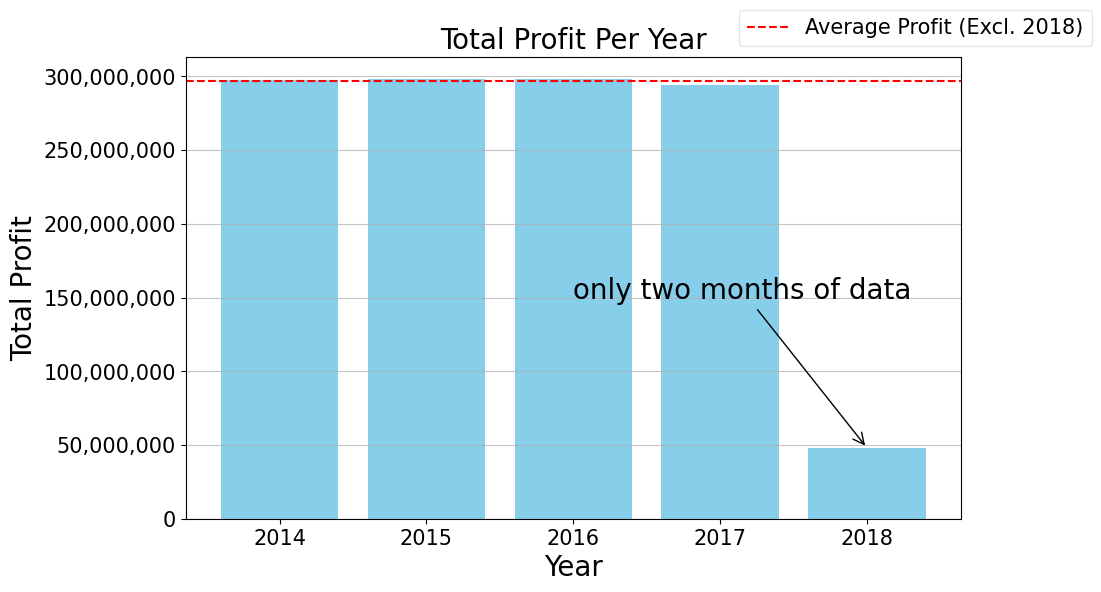

In [6]:
profit_per_year = df_merged_clean.groupby(df_merged_clean['Order Date'].dt.year)['Line Total'].sum()
print(profit_per_year)
average_profit = np.mean(profit_per_year[profit_per_year.index != 2018])
print(f"Average profit (excluding 2018): {average_profit:.2f}")
plt.figure(figsize=(10, 6))
plt.bar(profit_per_year.index, profit_per_year.values, color='skyblue')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.title('Total Profit Per Year', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Total Profit', fontsize=20)
plt.xticks(profit_per_year.index, fontsize=15)
plt.yticks(fontsize=15)
plt.annotate('only two months of data', xy=(2018, profit_per_year[2018]), xytext=(2016, profit_per_year.max()*0.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')
plt.axhline(average_profit, color='red', linestyle='--', label='Average Profit (Excl. 2018)')
plt.legend(fontsize=15, frameon=True, framealpha=0.5, bbox_to_anchor=(0.7, 1))
plt.grid(True, axis='y', alpha=0.75)
savefig("total_profit_per_year")
plt.show()

Max profit month percentage: 2.14%
Min profit month percentage: 1.72%
Order Date
2014-01    25020272.3
2014-02    23882719.5
2014-03    23709035.4
2014-04    24853382.0
2014-05    25662165.8
2014-06    23818794.8
2014-07    23491988.9
2014-08    25408229.1
2014-09    25459497.5
2014-10    24259835.7
2014-11    26268221.0
2014-12    25686587.3
2015-01    25525914.6
2015-02    23027431.0
2015-03    24360945.4
2015-04    23744217.1
2015-05    24995904.4
2015-06    24528391.8
2015-07    24808203.9
2015-08    26155634.2
2015-09    24662586.1
2015-10    25466197.5
2015-11    25573136.2
2015-12    25562148.2
2016-01    24862829.0
2016-02    23151247.0
2016-03    26420512.0
2016-04    23179165.9
2016-05    25265324.8
2016-06    24804170.5
2016-07    24814997.7
2016-08    25082099.9
2016-09    24551560.4
2016-10    25896129.8
2016-11    25078997.8
2016-12    24976635.2
2017-01    24017201.9
2017-02    21241586.2
2017-03    26123159.3
2017-04    23447990.0
2017-05    26348721.5
2017-06    237613

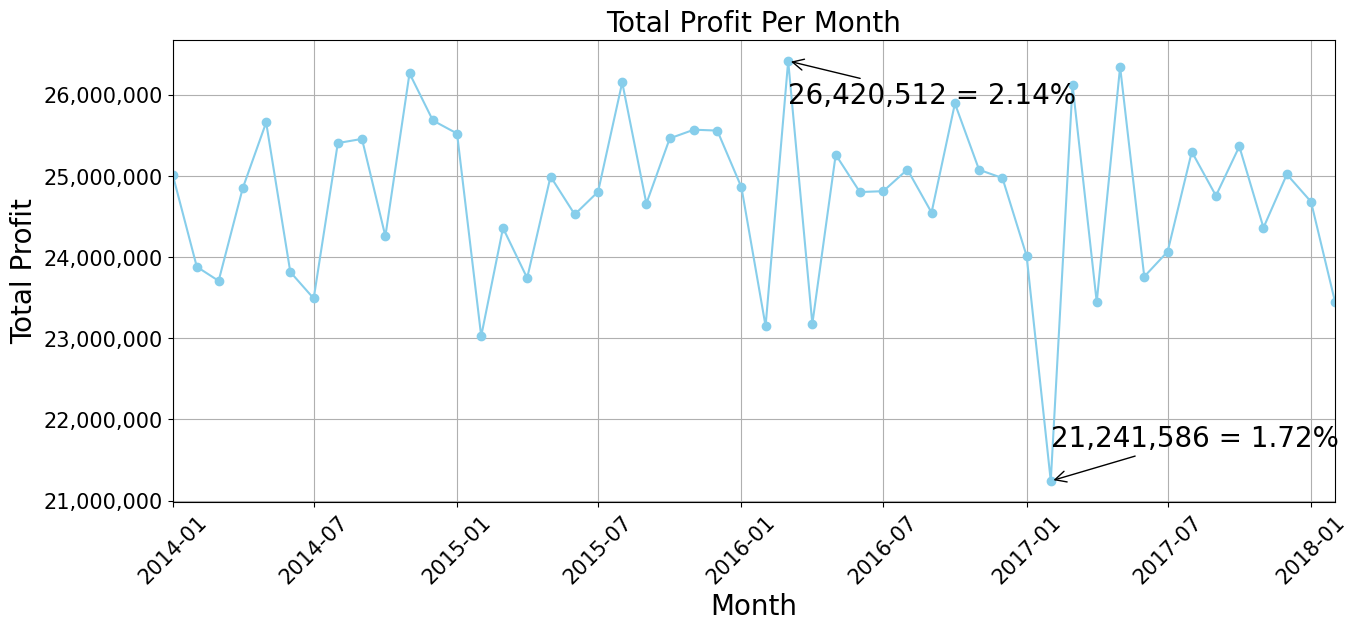

In [7]:
profit_per_month = df_merged_clean.groupby(df_merged_clean['Order Date'].dt.to_period('M'))['Line Total'].sum()
max_profit_percent = np.max(profit_per_month) / np.sum(profit_per_month) * 100
min_profit_percent = np.min(profit_per_month) / np.sum(profit_per_month) * 100
print(f"Max profit month percentage: {max_profit_percent:.2f}%")
print(f"Min profit month percentage: {min_profit_percent:.2f}%")


print(profit_per_month)
plt.figure(figsize=(15, 6))
plt.plot(profit_per_month.index.to_timestamp(), profit_per_month.values, marker='o', color='skyblue')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.title('Total Profit Per Month', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Total Profit', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.xlim(profit_per_month.index.to_timestamp().min(), profit_per_month.index.to_timestamp().max())
plt.yticks(fontsize=15)
plt.annotate(f"{profit_per_month.max():,.0f} = {max_profit_percent:.2f}%", xy=(profit_per_month.idxmax().to_timestamp(), profit_per_month.max()), xytext=(profit_per_month.idxmax().to_timestamp(), profit_per_month.max() * 0.98), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')
plt.annotate(f"{profit_per_month.min():,.0f} = {min_profit_percent:.2f}%", xy=(profit_per_month.idxmin().to_timestamp(), profit_per_month.min()), xytext=(profit_per_month.idxmin().to_timestamp(), profit_per_month.min() * 1.02), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')
plt.grid(True)
savefig("total_profit_per_month")
plt.show()

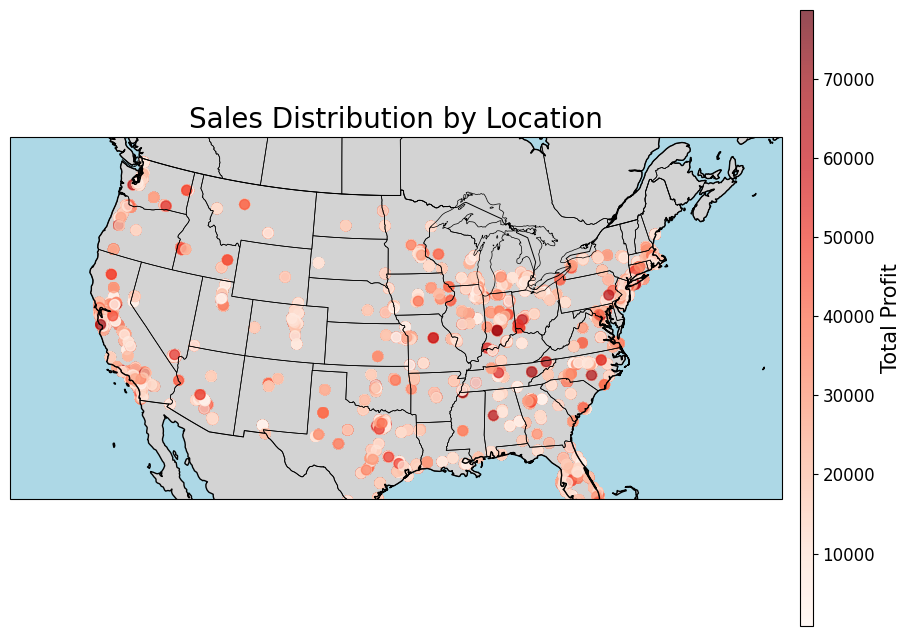

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.Geodetic())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.7)
ax.add_feature(cfeature.STATES, linewidth=0.5)

scatter = ax.scatter(df_merged_clean['longitude'], df_merged_clean['latitude'],
                     c=df_merged_clean['Line Total'], cmap='Reds', s=50,
                     alpha=0.7, transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Total Profit', fontsize=15)
cbar.ax.tick_params(labelsize=12)
plt.title('Sales Distribution by Location', fontsize=20)
savefig("sales_distribution_by_location")
plt.show()

Aibox Company: 12,641,252 (1.02%)
State Ltd: 12,220,639 (0.99%)
Pixoboo Corp: 10,986,459 (0.89%)
Organon Corp: 10,955,827 (0.89%)
Realbuzz Ltd: 10,753,299 (0.87%)
WOCKHARDT Group: 10,701,964 (0.87%)
Kare Corp: 10,635,634 (0.86%)
Colgate-Pa Group: 10,107,004 (0.82%)
Golden Corp: 10,007,669 (0.81%)
Deseret Group: 9,942,224 (0.80%)
Customer Names
Aibox Company       12641251.8
State Ltd           12220639.2
Pixoboo Corp        10986459.0
Organon Corp        10955826.6
Realbuzz Ltd        10753299.0
WOCKHARDT Group     10701963.6
Kare Corp           10635633.6
Colgate-Pa Group    10107003.6
Golden Corp         10007669.4
Deseret Group        9942223.8
Name: Line Total, dtype: float64


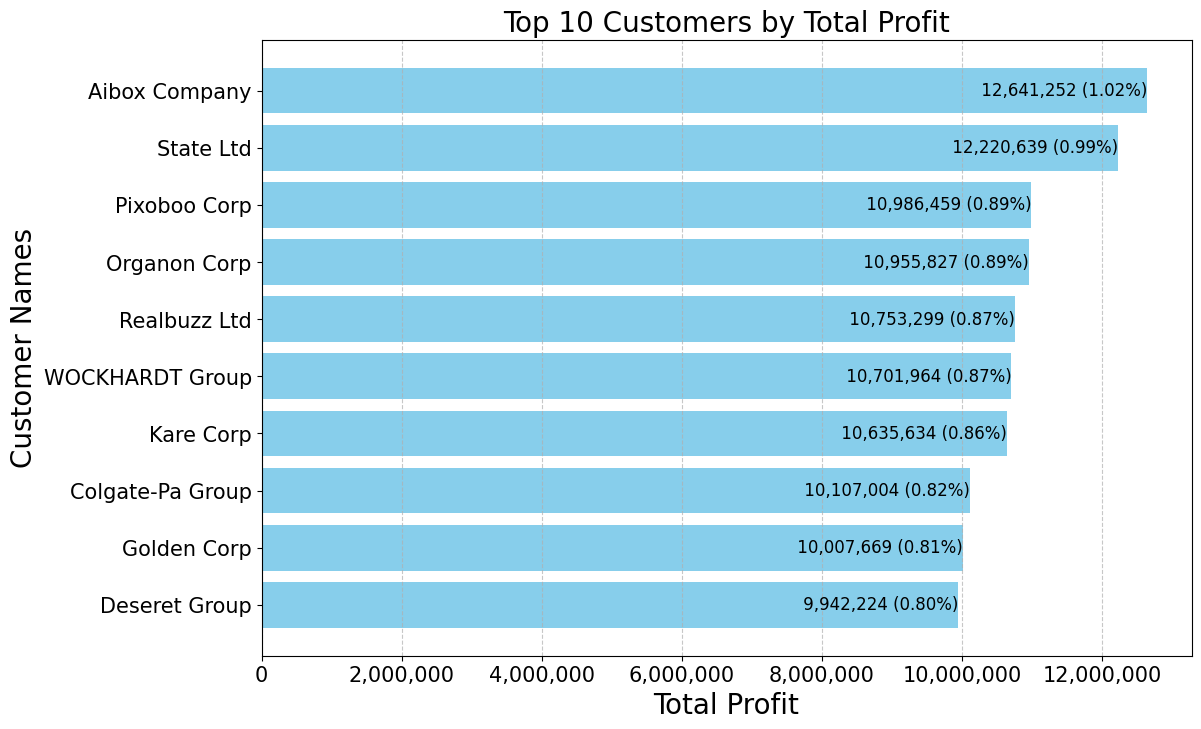

In [9]:
top_10_customers = (df_merged_clean.groupby('Customer Names')['Line Total'].sum()
                   .sort_values(ascending=False).head(10))
for customer, profit in top_10_customers.items():
    customer_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    print(f"{customer}: {profit:,.0f} ({customer_percent:.2f}%)")

print(top_10_customers)
plt.figure(figsize=(12, 8))
plt.barh(top_10_customers.index, top_10_customers.values, color='skyblue')
plt.title('Top 10 Customers by Total Profit', fontsize=20)
plt.xlabel('Total Profit', fontsize=20)
plt.ylabel('Customer Names', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i, (customer, profit) in enumerate(top_10_customers.items()):
    customer_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    plt.text(profit, i, f' {profit:,.0f} ({customer_percent:.2f}%)', va='center', ha='right', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
savefig("top_10_customers")
plt.show()

Johnson Ltd: 5,083,411 (0.41%)
Zoomdog Corp: 5,047,914 (0.41%)
Aveda Group: 5,037,100 (0.41%)
Quaxo Ltd: 5,026,206 (0.41%)
Epic Group: 4,807,960 (0.39%)
SEINDNI Corp: 4,760,162 (0.39%)
Voonyx Group: 4,670,918 (0.38%)
Mycone Ltd: 4,534,238 (0.37%)
Yodoo Ltd: 4,372,755 (0.35%)
BB17 Company: 4,034,673 (0.33%)
Customer Names
Johnson Ltd     5083410.6
Zoomdog Corp    5047914.0
Aveda Group     5037100.2
Quaxo Ltd       5026206.0
Epic Group      4807960.2
SEINDNI Corp    4760162.4
Voonyx Group    4670918.4
Mycone Ltd      4534238.4
Yodoo Ltd       4372755.0
BB17 Company    4034673.0
Name: Line Total, dtype: float64


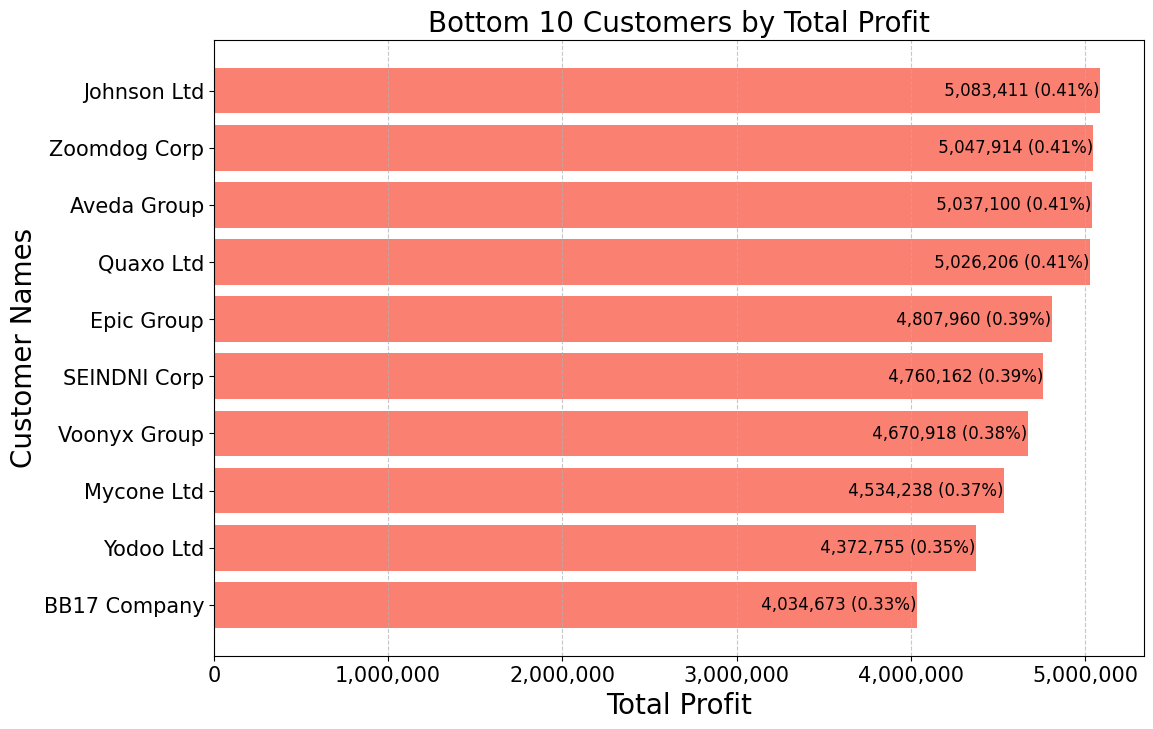

In [10]:
bottom_10_customers = (df_merged_clean.groupby('Customer Names')['Line Total'].sum()
                      .sort_values(ascending=False).tail(10))
for customer, profit in bottom_10_customers.items():
    customer_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    print(f"{customer}: {profit:,.0f} ({customer_percent:.2f}%)")

print(bottom_10_customers)
plt.figure(figsize=(12, 8))
plt.barh(bottom_10_customers.index, bottom_10_customers.values, color='salmon')
plt.title('Bottom 10 Customers by Total Profit', fontsize=20)
plt.xlabel('Total Profit', fontsize=20)
plt.ylabel('Customer Names', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i, (customer, profit) in enumerate(bottom_10_customers.items()):
    customer_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    plt.text(profit, i, f' {profit:,.0f} ({customer_percent:.2f}%)', va='center', ha='right', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
savefig("bottom_10_customers")
plt.show()

Product 26: 117,291,821 (9.49%)
Product 25: 109,473,967 (8.86%)
Product 13: 78,281,380 (6.33%)
Product 14: 75,390,397 (6.10%)
Product 5: 70,804,381 (5.73%)
Product 15: 67,331,623 (5.45%)
Product 2: 57,401,098 (4.64%)
Product 4: 56,701,537 (4.59%)
Product 1: 55,952,290 (4.53%)
Product 3: 51,764,816 (4.19%)
Product Name
Product 26    117291821.4
Product 25    109473966.6
Product 13     78281379.6
Product 14     75390396.6
Product 5      70804380.6
Product 15     67331623.2
Product 2      57401097.6
Product 4      56701537.2
Product 1      55952289.6
Product 3      51764816.4
Name: Line Total, dtype: float64


/var/folders/_1/_qs6rq1s5l5c7t2_v39s6scw0000gn/T/ipykernel_3775/1057765324.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(0, top_10_products[0] * 1.1)


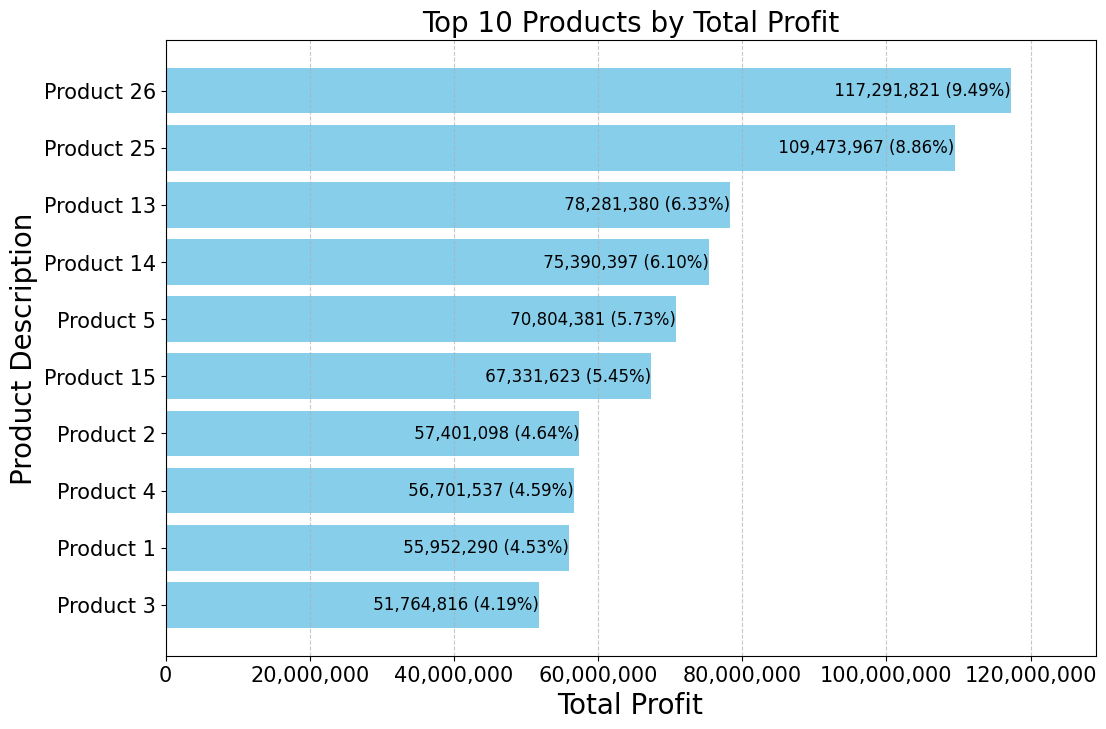

In [11]:
top_10_products = (df_merged_clean.groupby('Product Name')['Line Total'].sum()
                   .sort_values(ascending=False).head(10))
for product, profit in top_10_products.items():
    product_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    print(f"{product}: {profit:,.0f} ({product_percent:.2f}%)")

print(top_10_products)
plt.figure(figsize=(12, 8))
plt.barh(top_10_products.index, top_10_products.values, color='skyblue')
plt.title('Top 10 Products by Total Profit', fontsize=20)
plt.xlabel('Total Profit', fontsize=20)
plt.ylabel('Product Description', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i, (product, profit) in enumerate(top_10_products.items()):
    product_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    plt.text(profit, i, f' {profit:,.0f} ({product_percent:.2f}%)', va='center', ha='right', fontsize=12)
plt.xlim(0, top_10_products[0] * 1.1)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
savefig("top_10_products")
plt.show()

Product 21: 19,246,876 (1.56%)
Product 23: 18,856,855 (1.53%)
Product 30: 18,590,168 (1.50%)
Product 27: 18,377,792 (1.49%)
Product 10: 17,660,584 (1.43%)
Product 7: 17,058,267 (1.38%)
Product 22: 15,638,202 (1.27%)
Product 29: 15,311,014 (1.24%)
Product 9: 14,598,630 (1.18%)
Product 24: 14,555,053 (1.18%)
Product Name
Product 21    19246875.6
Product 23    18856855.2
Product 30    18590168.4
Product 27    18377791.8
Product 10    17660583.6
Product 7     17058267.0
Product 22    15638202.0
Product 29    15311014.2
Product 9     14598630.0
Product 24    14555053.2
Name: Line Total, dtype: float64


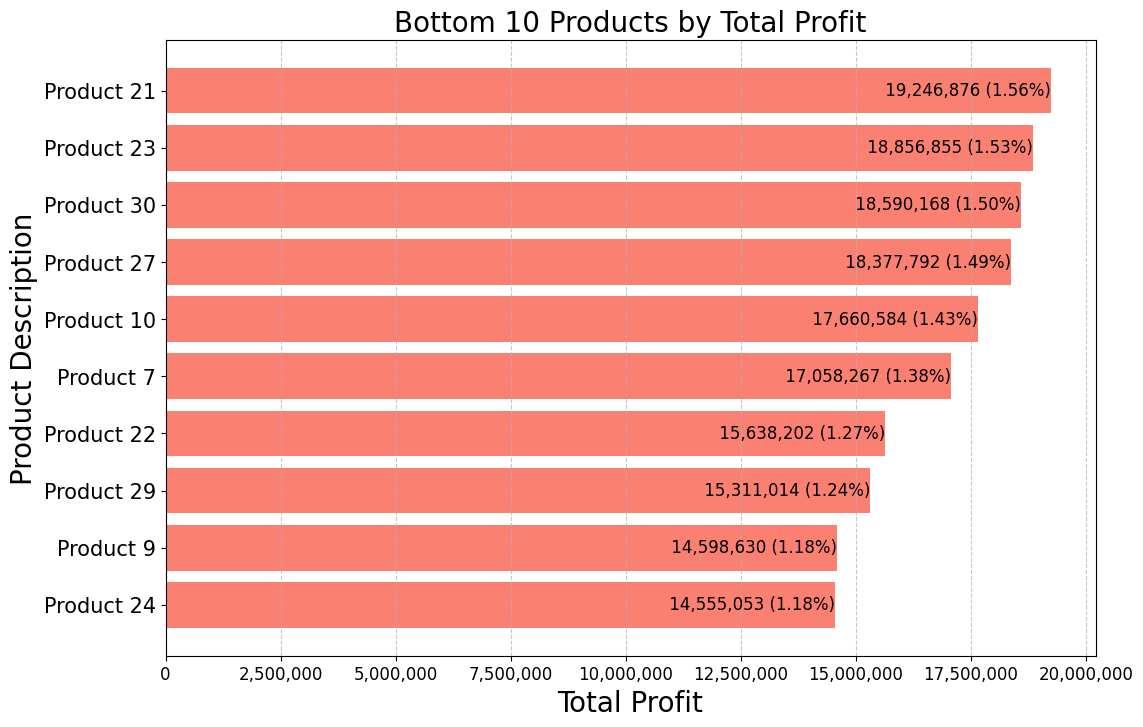

In [12]:
bottom_10_products = (df_merged_clean.groupby('Product Name')['Line Total'].sum()
                      .sort_values(ascending=False).tail(10))
for product, profit in bottom_10_products.items():
    product_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    print(f"{product}: {profit:,.0f} ({product_percent:.2f}%)")
print(bottom_10_products)
plt.figure(figsize=(12, 8))
plt.barh(bottom_10_products.index, bottom_10_products.values, color='salmon')
plt.title('Bottom 10 Products by Total Profit', fontsize=20)
plt.xlabel('Total Profit', fontsize=20)
plt.ylabel('Product Description', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
for i, (product, profit) in enumerate(bottom_10_products.items()):
    product_percent = (profit / df_merged_clean['Line Total'].sum()) * 100
    plt.text(profit, i, f' {profit:,.0f} ({product_percent:.2f}%)', va='center', ha='right', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
savefig("bottom_10_products")
plt.show()

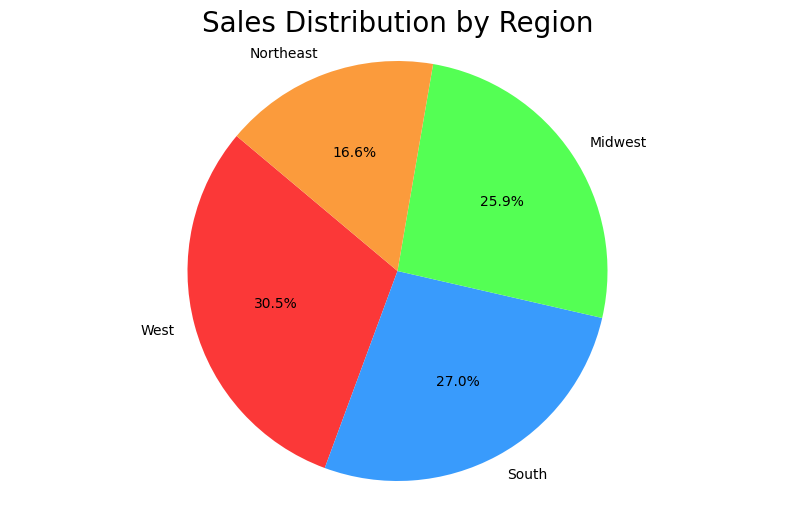

In [13]:
plt.figure(figsize=(10, 6))
plt.pie(df_merged_clean['Region'].value_counts(), labels=df_merged_clean['Region'].value_counts().index, autopct='%1.1f%%', startangle=140, colors=["#fb3838","#399bfc","#54ff54","#fb9b3c"])
plt.title('Sales Distribution by Region', fontsize=20)
plt.axis('equal')
savefig("sales_distribution_by_region")
plt.show()

Region        Midwest  Northeast      South       West
Order Date                                            
2014-01     6284680.4  4692458.9  7115976.2  6927156.8
2014-02     6321825.2  3753494.1  7221179.6  6586220.6
2014-03     5891115.7  4195352.4  6078072.5  7544494.8
2014-04     6448408.3  3715156.7  6546121.1  8143695.9
2014-05     7159908.1  3818691.8  6813357.3  7870208.6
2014-06     5625695.2  4231318.0  6367144.0  7594637.6
2014-07     6545216.6  3676625.0  5972895.9  7297251.4
2014-08     6666553.6  4021909.5  6880323.8  7839442.2
2014-09     6650875.6  4250205.3  7131614.0  7426802.6
2014-10     6329691.0  3797874.9  6379204.0  7753065.8
2014-11     6942446.2  4802137.9  7087789.3  7435847.6
2014-12     7068794.8  4038639.4  6809364.1  7769789.0
2015-01     6786925.8  3920136.5  7141798.0  7677054.3
2015-02     6090809.2  4027530.8  5589066.3  7320024.7
2015-03     6100463.9  4164344.8  6790577.3  7305559.4
2015-04     6195959.0  4178769.9  6599620.6  6769867.6
2015-05   

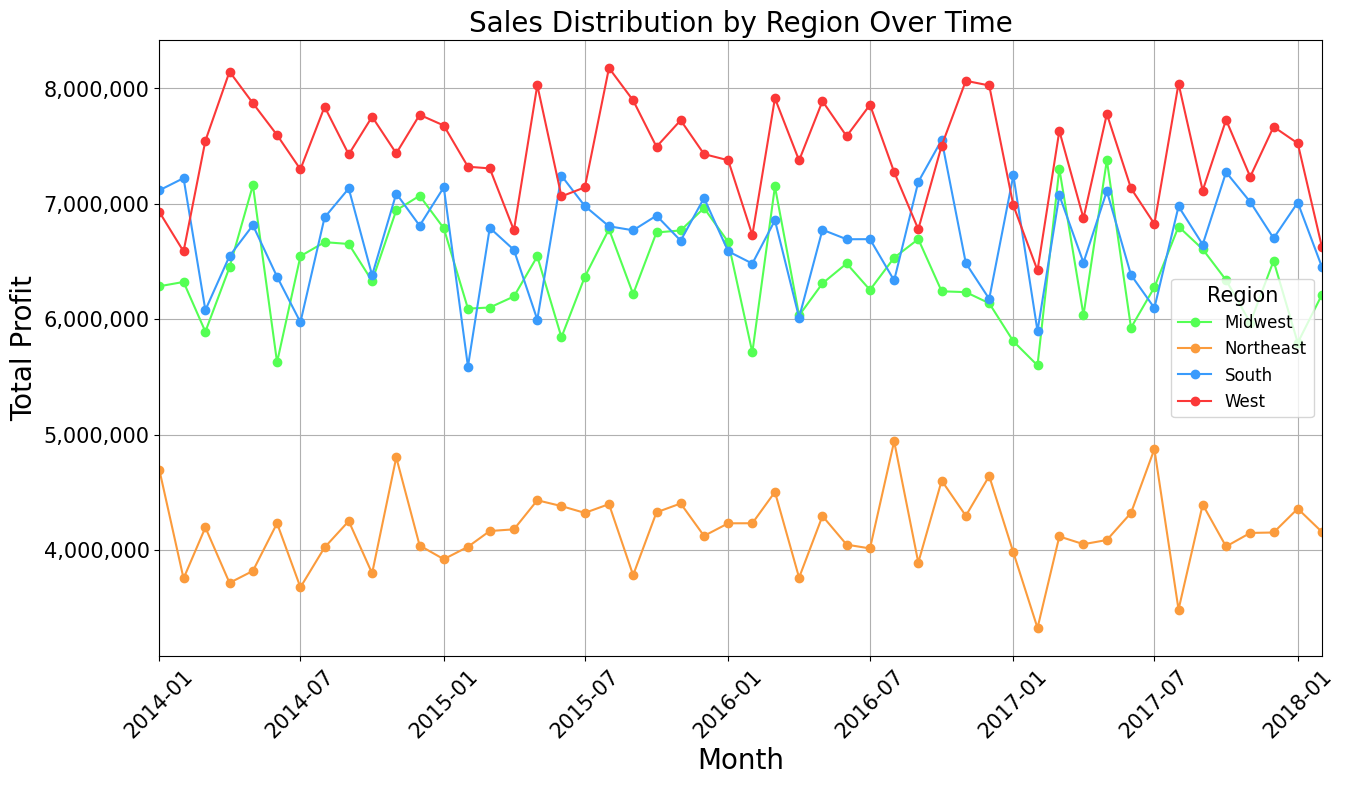

In [14]:
region_distribution_by_month = (df_merged_clean.groupby([df_merged_clean['Order Date'].dt.to_period('M'), 'Region'])['Line Total'].sum()
                               .unstack().fillna(0))
print(region_distribution_by_month)
region_distribution_by_month.index = region_distribution_by_month.index.to_timestamp()
plt.figure(figsize=(15, 8))
for region in region_distribution_by_month.columns:
    plt.plot(region_distribution_by_month.index, region_distribution_by_month[region], marker='o', label=region, color={"West":"#fb3838","South":"#399bfc","Midwest":"#54ff54","Northeast":"#fb9b3c"}[region])
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.title('Sales Distribution by Region Over Time', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Total Profit', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.xlim(region_distribution_by_month.index.min(), region_distribution_by_month.index.max())
plt.yticks(fontsize=15)
plt.legend(title='Region', fontsize=12, title_fontsize=15)
plt.grid(True)
savefig("sales_distribution_by_region_over_time")
plt.show()

([<matplotlib.patches.Wedge at 0x1207e79d0>,
 [Text(-0.596792086974828, -0.9240342011658602, 'Wholesale'),
  Text(0.9491954671176241, 0.5559028379162634, 'Distributor'),
  Text(-0.43355279644019434, 1.0109559697132648, 'Export')],
 [Text(-0.32552295653172436, -0.5040186551813782, '54.0%'),
  Text(0.5177429820641586, 0.3032197297725073, '31.1%'),
  Text(-0.23648334351283326, 0.551430528934508, '14.9%')])

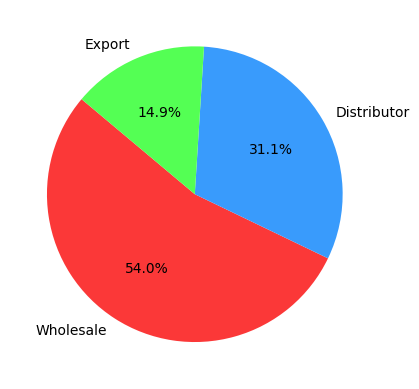

In [15]:
plt.Figure(figsize=(10, 6))
channel_counts = df_merged_clean['Channel'].value_counts()
channel_labels = channel_counts.index.to_list()
channel_palette = ["#fb3838","#399bfc","#54ff54"]
plt.pie(channel_counts, labels=channel_labels, autopct='%1.1f%%', startangle=140, colors=channel_palette)

Channel     Distributor     Export   Wholesale
Order Date                                    
2014-01       7815422.7  3737561.5  13467288.1
2014-02       7840621.4  3392786.2  12649311.9
2014-03       7207424.5  3242404.7  13259206.2
2014-04       7551972.0  3446138.3  13855271.7
2014-05       7531496.8  3994178.2  14136490.8
2014-06       7523664.5  3566095.1  12729035.2
2014-07       7288467.7  3367466.9  12836054.3
2014-08       8536778.2  3464817.9  13406633.0
2014-09       8253991.3  3771282.6  13434223.6
2014-10       7721488.7  3482814.1  13055532.9
2014-11       8589540.7  3541352.0  14137328.3
2014-12       7843254.5  3517031.0  14326301.8
2015-01       6819494.5  4256690.9  14449729.2
2015-02       7065907.1  4045620.8  11915903.1
2015-03       8221054.1  3476502.7  12663388.6
2015-04       7603736.2  3414601.4  12725879.5
2015-05       8084280.3  3789520.0  13122104.1
2015-06       7447371.6  3383821.6  13697198.6
2015-07       7209535.0  4150241.3  13448427.6
2015-08      

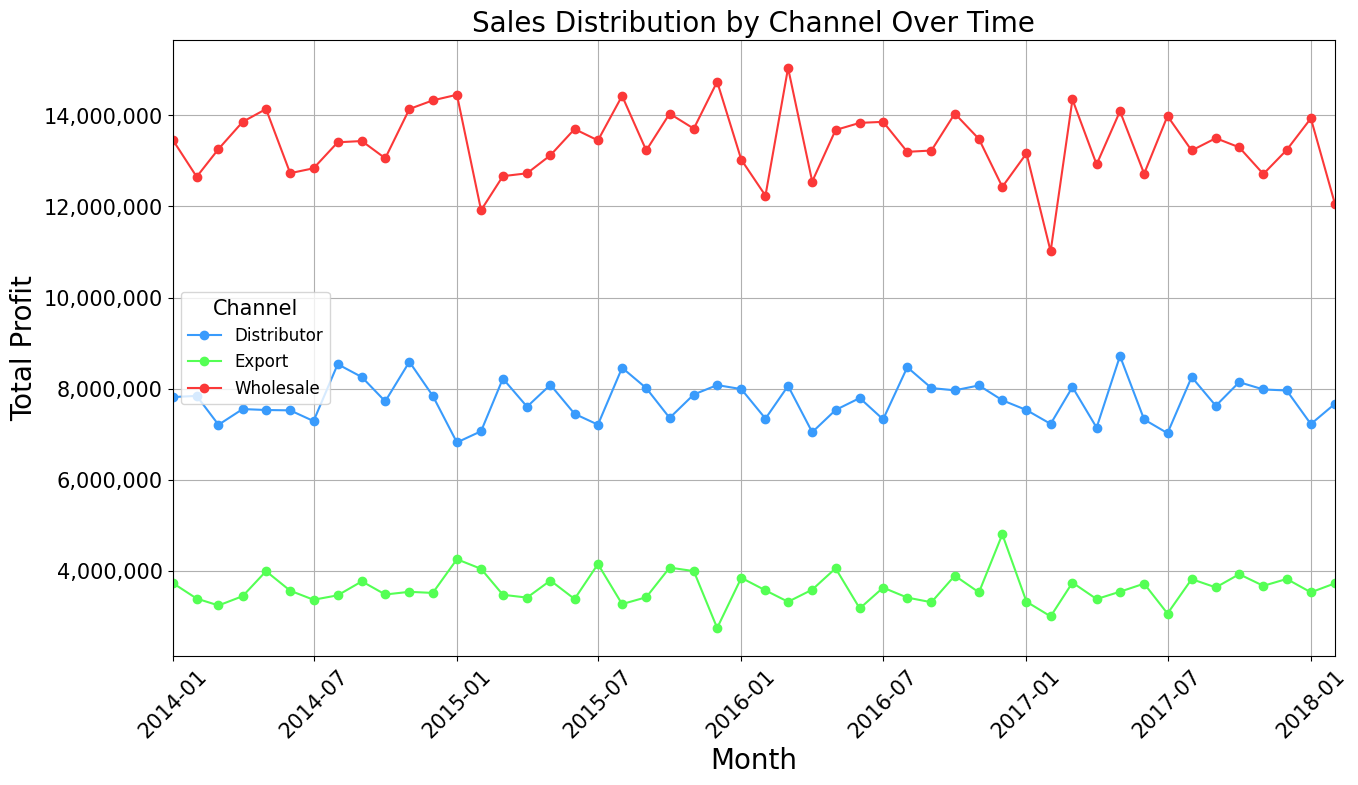

In [16]:
channel_by_month = (df_merged_clean.groupby([df_merged_clean['Order Date'].dt.to_period('M'), 'Channel'])['Line Total'].sum()
                   .unstack().fillna(0))
print(channel_by_month)
channel_by_month.index = channel_by_month.index.to_timestamp()
plt.figure(figsize=(15, 8))
for channel in channel_by_month.columns:
    plt.plot(channel_by_month.index, channel_by_month[channel], marker='o', label=channel, color={"Wholesale":"#fb3838","Distributor":"#399bfc","Export":"#54ff54"}[channel])
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{x:,.0f}"))
plt.title('Sales Distribution by Channel Over Time', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Total Profit', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.xlim(channel_by_month.index.min(), channel_by_month.index.max())
plt.yticks(fontsize=15)
plt.legend(title='Channel', fontsize=12, title_fontsize=15)
plt.grid(True)
savefig("sales_distribution_by_channel_over_time")
plt.show()